### Fraud detection using SVC and Logistic Regression
In this notebook I will demonstate the use of two models that can be used for fraud detection: Support Vector Classification (SVC) and Logistic Regression. These models are suitable for Fraud detection, as the problem can be considered a binary classification one; in the dataset used, the target variable, 'isFraud', is 0 for non-fraud and 1 for fraud transactions.
I first evaluate a SCV model with default hyperparameters. I then evaluate a SVC model where the hyperparameters are set using the GridSearchCV class. Finally, I evaluate a Logistic Regression Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_score,auc,roc_auc_score,roc_curve,recall_score

### Read the data

In [2]:
# Import the dataset
# note: the dataset is a Kaggle dataset, Synthetic Financial Datasets For Fraud Detection (TESTIMON@NTNU)
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


Drop features that will not add value in predicting if an observation is fraudulent. 
note: step is the freq that the account is used

In [3]:
df.drop('nameOrig', axis=1, inplace=True)
df.drop('nameDest', axis=1, inplace=True)
df.drop('isFlaggedFraud', axis=1, inplace=True)

Get a sample, limitations of home PC in processing the large dataset  
sample should be balanced

In [4]:
n_frauds = df['isFraud'].value_counts()[1]
n_non_frauds = df['isFraud'].value_counts()[0]

# keep all the fraud records for our sample
fraud_recs = df[df['isFraud'] == 1]

# get a shuffled sample of non-fraud records, 5 times the size of the fraud records
non_fraud_recs = df[df['isFraud'] == 0].sample(frac=(n_frauds * 5) / n_non_frauds)

print(fraud_recs.shape, non_fraud_recs.shape)

(8213, 8) (41065, 8)


In [5]:
# join the two sub samples and shuffle
sample_data = non_fraud_recs.append(fraud_recs)
sample_data = sample_data.sample(frac=1)
sample_data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2744077,212,CASH_OUT,94357.83,0.00,0.00,210098.05,304455.88,0
5727827,399,CASH_OUT,1442075.90,1442075.90,0.00,168728.60,1610804.50,1
1595392,156,CASH_OUT,569942.69,316825.00,0.00,0.00,569942.69,0
3485111,258,PAYMENT,3053.94,94004.08,90950.14,0.00,0.00,0
6157374,548,PAYMENT,3750.96,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...
275287,15,TRANSFER,394056.10,0.00,0.00,451486.32,1046707.13,0
22593,8,CASH_OUT,222947.46,6190.00,0.00,117954.28,542692.36,0
4603332,329,CASH_OUT,77941.72,0.00,0.00,294431.39,372373.11,0
5670248,397,CASH_IN,75662.95,21569.00,97231.95,397653.75,321990.80,0


### Preprocess
Although you would normally perform detailed Exploratory Data Analysis,  as the purpose of this notebook is to describe how Python can be used to predict fraudulant records I will go straight into modelling the data

In [6]:
# check for NANs 
sample_data.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [7]:
# get feature matrix and target matrix
X = sample_data.drop('isFraud',axis=1).values
y = sample_data['isFraud'].values

# Split the data into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=124)


In [8]:
# one hot encode a column in an array
# note: this function is needed as to one hot encode the whole array led to memory issues on PC
def ohe(arr,pos):
    enc = OneHotEncoder(handle_unknown='ignore')
    ohe_col = arr[:,pos]
    ohe_col = np.reshape(ohe_col,(len(ohe_col),1))

    enc.fit(ohe_col)
    ohe_vals = enc.transform(ohe_col).toarray()

    # remove the original category column from array
    arr_new = np.delete(arr, pos, axis=1)
    
    # append the one hot encoded values to array
    arr_new = np.hstack((arr_new,ohe_vals))

    return arr_new

In [9]:
# transaction type column, col 1, is categorical, one hot encode
print('\nX_Train before OHE: \n',X_train)

X_train = ohe(X_train,1)
print('\n\nX_Train after OHE: \n',X_train)


X_Train before OHE: 
 [[235 'CASH_IN' 97500.46 ... 8824315.78 890036.92 821705.09]
 [374 'TRANSFER' 177790.67 ... 0.0 4306022.56 4483813.23]
 [40 'CASH_OUT' 244171.15 ... 66294.85 0.0 726591.17]
 ...
 [332 'CASH_OUT' 141900.65 ... 0.0 599320.98 741221.64]
 [38 'CASH_OUT' 3372.0 ... 0.0 456659.44 460031.44]
 [212 'PAYMENT' 7046.49 ... 0.0 0.0 0.0]]


X_Train after OHE: 
 [[235 97500.46 8726815.32 ... 0.0 0.0 0.0]
 [374 177790.67 99189.27 ... 0.0 0.0 1.0]
 [40 244171.15 310466.0 ... 0.0 0.0 0.0]
 ...
 [332 141900.65 0.0 ... 0.0 0.0 0.0]
 [38 3372.0 3372.0 ... 0.0 0.0 0.0]
 [212 7046.49 6904.0 ... 0.0 1.0 0.0]]


In [10]:
# scale the features
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)

### Evaluation metrics
Often a base test is created to provide a base accuracy score. I set the base test data to all zeros to simulate how accurate a model that just reports every transaction as non-fraud would be. In this case the accuracy is 83%. 
Accuracy measures how many predictions were correct, and considers both predictions of fraud and non-fraud cases. However, our main concern is predicting fraud cases and so we need to focus on the Recall metric. In the base model, the Recall metric for the fraud class (class 1) is 0.00, indicating that we would flag no transactions as fraudulent. 

In [12]:
# base test
base_test = np.zeros_like(y_test)

print("\nBase test accuracy:",metrics.accuracy_score(y_test, base_test))
print ("\nBase test Classification Report:")
print (metrics.classification_report(y_test, base_test))


Base test accuracy: 0.833502435064935

Base test Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      8215
           1       0.00      0.00      0.00      1641

    accuracy                           0.83      9856
   macro avg       0.42      0.50      0.45      9856
weighted avg       0.69      0.83      0.76      9856



### SVM model
The first model I will evaluate is Support Vector Classification, using the default hyperparameters. 


In [13]:
# preprocess X_test
X_test = ohe(X_test,1)
X_test = sc.fit_transform(X_test)

In [32]:
# Create a svm Classifier
svc_clf = SVC(class_weight={0:1/6})

# Train the model using the training sets
svc_clf.fit(X_train, y_train.ravel())

# Predict the response for test dataset
y_hat_svc = svc_clf.predict(X_test)

In [33]:
# evaluating the default SVC model
print("\nDefault SVM Accuracy:",metrics.accuracy_score(y_test, y_hat_svc))
print ("\nDefault SVM Classification Report:")
print (metrics.classification_report(y_test, y_hat_svc))


Default SVM Accuracy: 0.8582589285714286

Default SVM Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      8215
           1       0.55      0.83      0.66      1641

    accuracy                           0.86      9856
   macro avg       0.76      0.85      0.79      9856
weighted avg       0.89      0.86      0.87      9856



While the accuracy of the SVC model is an improvement over the base model, 86% compared to 83%, the figure to note is the Recall for fraud cases, 83%, meaning that the model will predict 83% of actual fraudulent cases.

The above model uses the default hyperparameters, it is possible to fine tune a SVC model by configuring the hyperparameters. The scikit learn package provides the GridSearchCV class to facilitate the selection of hyperparameter values by running the model for each combination of values in a parameter grid.

In [34]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1e3,1e4,1e5]}]

grid = GridSearchCV(SVC(class_weight={0:1/6}),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train.ravel())

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  27.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.1s remaining:    0.0s


[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  26.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  26.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  26.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  25.9s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=  36.8s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=  37.2s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=  36.7s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .

[CV] .......................... C=1000.0, kernel=linear, total=   9.0s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  18.8s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  17.2s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  18.9s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  18.9s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  16.5s
[CV] C=100000.0, kernel=linear .......................................
[CV] ........................ C=100000.0, kernel=linear, total= 1.3min
[CV] C=100000.0, kernel=linear .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 26.6min finished


GridSearchCV(estimator=SVC(class_weight={0: 0.16666666666666666}),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000.0, 10000.0, 100000.0],
                          'kernel': ['linear']}],
             verbose=2)

In [35]:
# evaluate the grid SVC model
y_hat_grid = grid.predict(X_test)

print('\nHyperparameters for best estimator: ',grid.best_estimator_)

print("\nGrid SVM Accuracy:",metrics.accuracy_score(y_test, y_hat_grid))

print ("\nGrid SVM Classification Report:")
print(classification_report(y_test,y_hat_grid))


Hyperparameters for best estimator:  SVC(C=100000.0, class_weight={0: 0.16666666666666666}, kernel='linear')

Grid SVM Accuracy: 0.9387175324675324

Grid SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8215
           1       0.74      0.97      0.84      1641

    accuracy                           0.94      9856
   macro avg       0.87      0.95      0.90      9856
weighted avg       0.95      0.94      0.94      9856



By selecting hyperparameters of C=100000 and kernel=linear we can improve the accuracy of the SVC model to 94%, and, more importantly, improve the Recall metric for fraudulent transactions to 97%.

### Receiver Operating Characteristic
Binary classification models can be compared using receiver operating characteristic (ROC) curves.
Below I show how to get details of the confusion matrix and plot the ROC curve.

In [36]:
print("\nGrid SVM Accuracy:", metrics.accuracy_score(y_test, y_hat_grid))
print("\nGrid SVM Precision:", metrics.precision_score(y_test, y_hat_grid))
print("\nGrid SVM Recall:", metrics.recall_score(y_test, y_hat_grid))

confusion_mtx = metrics.confusion_matrix(y_test, y_hat_grid)
print("\nGrid SVM Confusion Matrix\n",confusion_mtx)


Grid SVM Accuracy: 0.9387175324675324

Grid SVM Precision: 0.7412750116333178

Grid SVM Recall: 0.9707495429616088

Grid SVM Confusion Matrix
 [[7659  556]
 [  48 1593]]


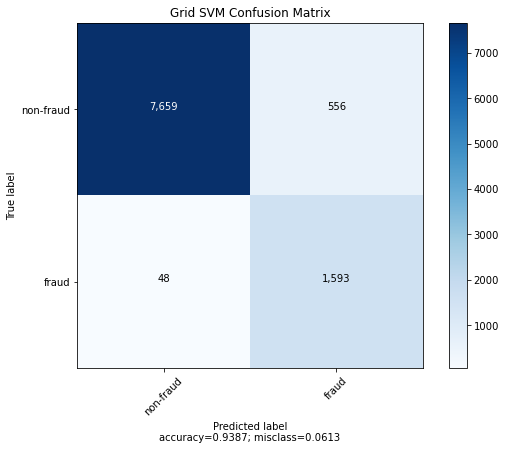

In [37]:
# the following function, from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# provides a more informative confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


plot_confusion_matrix(confusion_mtx, 
                     normalize    = False,
                     target_names = ['non-fraud', 'fraud'],
                     title        = "Grid SVM Confusion Matrix")

This confusion matrix indicates that of the 1,641 total True fraud transactions, the model predicted 48 as non-fraud and 1,593 as fraud. Recall is 0.970749, or 1,593 predicted fraud out of the 1,641 true cases.

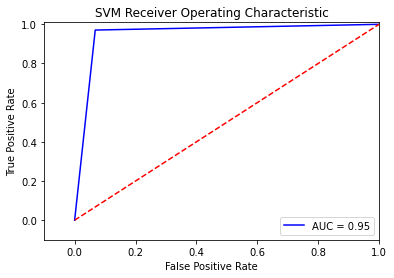

In [38]:
# Plot the ROC curve
roc = metrics.roc_auc_score(y_test, y_hat_grid) 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat_grid) 
roc_auc = auc(fpr,tpr)

plt.title('SVM Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression 
Logistic regression is another popular model for binary classification. Again I will use a parameter grid and GridSearchCV to optimise the hyperparameters

In [39]:
param_grid = [
                {'solver': [ 'newton-cg', 'lbfgs',  'sag'],
                     'penalty': [ 'l2'], 
                     'C': [1, 10, 100, 1e3,1e4,1e5]},
                {'solver': ['liblinear'], 
                     'C': [1, 10, 100, 1e3,1e4,1e5], 
                     'penalty': [ 'l1', 'l2']},
                {'solver': ['saga'], 
                     'C': [1, 10, 100, 1e3,1e4,1e5], 
                     'penalty': [ 'l1', 'l2','elasticnet','none']} 
             ]

grid = GridSearchCV(LogisticRegression(max_iter =400,class_weight={0:1/6} ),param_grid,scoring='recall',refit=True,verbose=2)
grid.fit(X_train,y_train.ravel())

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] C=1, penalty=l2, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1, penalty=l2, solver=newton-cg ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................ C=1, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1, penalty=l2, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1, penalty=l2, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1, penalty=l2, solver=newton-cg ...............................
[CV] ................ C=1, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] .................... C=1, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] .................... C=1, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] .................... C=1, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] .

C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................. C=1000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=1000.0, penalty=l2, solver=sag ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................. C=1000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=1000.0, penalty=l2, solver=sag ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................. C=1000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=1000.0, penalty=l2, solver=sag ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................. C=1000.0, penalty=l2, solver=sag, total=   2.3s
[CV] C=1000.0, penalty=l2, solver=sag ................................
[CV] ................. C=1000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=10000.0, penalty=l2, solver=newton-cg .........................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .......... C=10000.0, penalty=l2, solver=newton-cg, total=   0.4s
[CV] C=10000.0, penalty=l2, solver=newton-cg .........................
[CV] .......... C=10000.0, penalty=l2, solver=newton-cg, total=   0.5s
[CV] C=10000.0, penalty=l2, solver=newton-cg .........................
[CV] .......... C=10000.0, penalty=l2, solver=newton-cg, total=   0.5s
[CV] C=10000.0, penalty=l2, solver=newton-cg .........................
[CV] .......... C=10000.0, penalty=l2, solver=newton-cg, total=   0.5s
[CV] C=10000.0, penalty=l2, solver=newton-cg .........................
[CV] .......... C=10000.0, penalty=l2, solver=newton-cg, total=   0.4s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................
[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   0.5s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................
[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   0.7s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................
[CV] .

C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   0.8s
[CV] C=10000.0, penalty=l2, solver=lbfgs .............................
[CV] .............. C=10000.0, penalty=l2, solver=lbfgs, total=   0.6s
[CV] C=10000.0, penalty=l2, solver=sag ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=10000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=10000.0, penalty=l2, solver=sag ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=10000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=10000.0, penalty=l2, solver=sag ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=10000.0, penalty=l2, solver=sag, total=   2.6s
[CV] C=10000.0, penalty=l2, solver=sag ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=10000.0, penalty=l2, solver=sag, total=   2.3s
[CV] C=10000.0, penalty=l2, solver=sag ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=10000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.5s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.6s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.7s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.7s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.7s
[CV] C=100000.0, penalty=l2, solver=lbfgs ............................
[CV] ............. C=100000.0, penalty=l2, solver=lbfgs, total=   0.5s
[CV] C=100000.0, penalty=l2, solver=lbfgs ............................
[CV] .

C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=100000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=100000.0, penalty=l2, solver=sag ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=100000.0, penalty=l2, solver=sag, total=   2.0s
[CV] C=100000.0, penalty=l2, solver=sag ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=100000.0, penalty=l2, solver=sag, total=   2.2s
[CV] C=100000.0, penalty=l2, solver=sag ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=100000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=100000.0, penalty=l2, solver=sag ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=100000.0, penalty=l2, solver=sag, total=   2.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=   0.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=   0.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=   0.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ................ C=1, penalty=l1, solver=liblinear, total=   0.1s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] ................ C=1, penalty=l2, solver=liblinear, total=   0.1s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] .

[CV] ......... C=100000.0, penalty=l2, solver=liblinear, total=   0.2s
[CV] C=100000.0, penalty=l2, solver=liblinear ........................
[CV] ......... C=100000.0, penalty=l2, solver=liblinear, total=   0.3s
[CV] C=100000.0, penalty=l2, solver=liblinear ........................
[CV] ......... C=100000.0, penalty=l2, solver=liblinear, total=   0.3s
[CV] C=1, penalty=l1, solver=saga ....................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=1, penalty=l1, solver=saga, total=   2.7s
[CV] C=1, penalty=l1, solver=saga ....................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=1, penalty=l1, solver=saga, total=   2.6s
[CV] C=1, penalty=l1, solver=saga ....................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=1, penalty=l1, solver=saga, total=   2.7s
[CV] C=1, penalty=l1, solver=saga ....................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=1, penalty=l1, solver=saga, total=   2.9s
[CV] C=1, penalty=l1, solver=saga ....................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ..................... C=1, penalty=l1, solver=saga, total=   2.7s
[CV] C=1, penalty=l2, solver=saga ....................................
[CV] ..................... C=1, penalty=l2, solver=saga, total=   0.2s
[CV] C=1, penalty=l2, solver=saga ....................................
[CV] ..................... C=1, penalty=l2, solver=saga, total=   0.2s
[CV] C=1, penalty=l2, solver=saga ....................................
[CV] ..................... C=1, penalty=l2, solver=saga, total=   0.2s
[CV] C=1, penalty=l2, solver=saga ....................................
[CV] ..................... C=1, penalty=l2, solver=saga, total=   0.2s
[CV] C=1, penalty=l2, solver=saga ....................................
[CV] ..................... C=1, penalty=l2, solver=saga, total=   0.2s
[CV] C=1, penalty=elasticnet, solver=saga ............................
[CV] ............. C=1, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=1, penalty=elasticnet, solver=saga ............................
[CV] .

C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=1, penalty=none, solver=saga, total=   2.3s
[CV] C=1, penalty=none, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=1, penalty=none, solver=saga, total=   2.3s
[CV] C=1, penalty=none, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=1, penalty=none, solver=saga, total=   2.3s
[CV] C=1, penalty=none, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=1, penalty=none, solver=saga, total=   2.4s
[CV] C=1, penalty=none, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=1, penalty=none, solver=saga, total=   2.5s
[CV] C=10, penalty=l1, solver=saga ...................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=   2.7s
[CV] C=10, penalty=l1, solver=saga ...................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=   2.7s
[CV] C=10, penalty=l1, solver=saga ...................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=   2.7s
[CV] C=10, penalty=l1, solver=saga ...................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=   2.7s
[CV] C=10, penalty=l1, solver=saga ...................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................... C=10, penalty=l1, solver=saga, total=   3.5s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=   1.0s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=   1.0s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=   0.7s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=   0.7s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] .................... C=10, penalty=l2, solver=saga, total=   0.7s
[CV] C=10, penalty=elasticnet, solver=saga ...........................
[CV] ............ C=10, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10, penalty=elasticnet, solver=saga ...........................
[CV] .

C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\adria\anaconda3\envs\tensorflow_env

[CV] .................. C=10, penalty=none, solver=saga, total=   2.3s
[CV] C=10, penalty=none, solver=saga .................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, solver=saga, total=   2.3s
[CV] C=10, penalty=none, solver=saga .................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, solver=saga, total=   2.3s
[CV] C=10, penalty=none, solver=saga .................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .................. C=10, penalty=none, solver=saga, total=   2.3s
[CV] C=10, penalty=none, solver=saga .................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .................. C=10, penalty=none, solver=saga, total=   2.4s
[CV] C=100, penalty=l1, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=   2.9s
[CV] C=100, penalty=l1, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=   2.7s
[CV] C=100, penalty=l1, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=   2.8s
[CV] C=100, penalty=l1, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=   2.7s
[CV] C=100, penalty=l1, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l1, solver=saga, total=   2.7s
[CV] C=100, penalty=l2, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=   2.3s
[CV] C=100, penalty=l2, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=   2.5s
[CV] C=100, penalty=l2, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=   2.3s
[CV] C=100, penalty=l2, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................... C=100, penalty=l2, solver=saga, total=   2.3s
[CV] C=100, penalty=l2, solver=saga ..................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\si

[CV] ................... C=100, penalty=l2, solver=saga, total=   2.3s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga ..........................
[CV] ........... C=100, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100, penalty=none, solver=saga ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................. C=100, penalty=none, solver=saga, total=   2.3s
[CV] C=100, penalty=none, solver=saga ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................. C=100, penalty=none, solver=saga, total=   2.3s
[CV] C=100, penalty=none, solver=saga ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................. C=100, penalty=none, solver=saga, total=   2.3s
[CV] C=100, penalty=none, solver=saga ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ................. C=100, penalty=none, solver=saga, total=   2.5s
[CV] C=100, penalty=none, solver=saga ................................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................. C=100, penalty=none, solver=saga, total=   2.3s
[CV] C=1000.0, penalty=l1, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l1, solver=saga, total=   2.7s
[CV] C=1000.0, penalty=l1, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=1000.0, penalty=l1, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=1000.0, penalty=l1, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=1000.0, penalty=l1, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l1, solver=saga, total=   3.2s
[CV] C=1000.0, penalty=l2, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l2, solver=saga, total=   2.5s
[CV] C=1000.0, penalty=l2, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l2, solver=saga, total=   3.3s
[CV] C=1000.0, penalty=l2, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l2, solver=saga, total=   2.5s
[CV] C=1000.0, penalty=l2, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................ C=1000.0, penalty=l2, solver=saga, total=   2.3s
[CV] C=1000.0, penalty=l2, solver=saga ...............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\si

[CV] ................ C=1000.0, penalty=l2, solver=saga, total=   2.4s
[CV] C=1000.0, penalty=elasticnet, solver=saga .......................
[CV] ........ C=1000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=1000.0, penalty=elasticnet, solver=saga .......................
[CV] ........ C=1000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=1000.0, penalty=elasticnet, solver=saga .......................
[CV] ........ C=1000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=1000.0, penalty=elasticnet, solver=saga .......................
[CV] ........ C=1000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=1000.0, penalty=elasticnet, solver=saga .......................
[CV] ........ C=1000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=1000.0, penalty=none, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .............. C=1000.0, penalty=none, solver=saga, total=   2.6s
[CV] C=1000.0, penalty=none, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .............. C=1000.0, penalty=none, solver=saga, total=   2.3s
[CV] C=1000.0, penalty=none, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .............. C=1000.0, penalty=none, solver=saga, total=   2.3s
[CV] C=1000.0, penalty=none, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] .............. C=1000.0, penalty=none, solver=saga, total=   2.3s
[CV] C=1000.0, penalty=none, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=1000.0, penalty=none, solver=saga, total=   2.3s
[CV] C=10000.0, penalty=l1, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=10000.0, penalty=l1, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l1, solver=saga, total=   3.0s
[CV] C=10000.0, penalty=l1, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=10000.0, penalty=l1, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l1, solver=saga, total=   3.0s
[CV] C=10000.0, penalty=l1, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=10000.0, penalty=l2, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l2, solver=saga, total=   2.3s
[CV] C=10000.0, penalty=l2, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l2, solver=saga, total=   2.4s
[CV] C=10000.0, penalty=l2, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l2, solver=saga, total=   2.6s
[CV] C=10000.0, penalty=l2, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............... C=10000.0, penalty=l2, solver=saga, total=   2.3s
[CV] C=10000.0, penalty=l2, solver=saga ..............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\si

[CV] ............... C=10000.0, penalty=l2, solver=saga, total=   2.3s
[CV] C=10000.0, penalty=elasticnet, solver=saga ......................
[CV] ....... C=10000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10000.0, penalty=elasticnet, solver=saga ......................
[CV] ....... C=10000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10000.0, penalty=elasticnet, solver=saga ......................
[CV] ....... C=10000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10000.0, penalty=elasticnet, solver=saga ......................
[CV] ....... C=10000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10000.0, penalty=elasticnet, solver=saga ......................
[CV] ....... C=10000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=10000.0, penalty=none, solver=saga ............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............. C=10000.0, penalty=none, solver=saga, total=   2.3s
[CV] C=10000.0, penalty=none, solver=saga ............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............. C=10000.0, penalty=none, solver=saga, total=   2.3s
[CV] C=10000.0, penalty=none, solver=saga ............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............. C=10000.0, penalty=none, solver=saga, total=   2.3s
[CV] C=10000.0, penalty=none, solver=saga ............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............. C=10000.0, penalty=none, solver=saga, total=   2.7s
[CV] C=10000.0, penalty=none, solver=saga ............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............. C=10000.0, penalty=none, solver=saga, total=   2.5s
[CV] C=100000.0, penalty=l1, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=100000.0, penalty=l1, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=100000.0, penalty=l1, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=100000.0, penalty=l1, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=100000.0, penalty=l1, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l1, solver=saga, total=   2.8s
[CV] C=100000.0, penalty=l2, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l2, solver=saga, total=   2.5s
[CV] C=100000.0, penalty=l2, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l2, solver=saga, total=   2.4s
[CV] C=100000.0, penalty=l2, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l2, solver=saga, total=   2.4s
[CV] C=100000.0, penalty=l2, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............. C=100000.0, penalty=l2, solver=saga, total=   2.3s
[CV] C=100000.0, penalty=l2, solver=saga .............................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\si

[CV] .............. C=100000.0, penalty=l2, solver=saga, total=   2.3s
[CV] C=100000.0, penalty=elasticnet, solver=saga .....................
[CV] ...... C=100000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100000.0, penalty=elasticnet, solver=saga .....................
[CV] ...... C=100000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100000.0, penalty=elasticnet, solver=saga .....................
[CV] ...... C=100000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100000.0, penalty=elasticnet, solver=saga .....................
[CV] ...... C=100000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100000.0, penalty=elasticnet, solver=saga .....................
[CV] ...... C=100000.0, penalty=elasticnet, solver=saga, total=   0.0s
[CV] C=100000.0, penalty=none, solver=saga ...........................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............ C=100000.0, penalty=none, solver=saga, total=   2.4s
[CV] C=100000.0, penalty=none, solver=saga ...........................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............ C=100000.0, penalty=none, solver=saga, total=   2.6s
[CV] C=100000.0, penalty=none, solver=saga ...........................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............ C=100000.0, penalty=none, solver=saga, total=   2.4s
[CV] C=100000.0, penalty=none, solver=saga ...........................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV] ............ C=100000.0, penalty=none, solver=saga, total=   2.4s
[CV] C=100000.0, penalty=none, solver=saga ...........................


C:\Users\adria\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.6min finished


[CV] ............ C=100000.0, penalty=none, solver=saga, total=   2.3s


GridSearchCV(estimator=LogisticRegression(class_weight={0: 0.16666666666666666},
                                          max_iter=400),
             param_grid=[{'C': [1, 10, 100, 1000.0, 10000.0, 100000.0],
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'C': [1, 10, 100, 1000.0, 10000.0, 100000.0],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [1, 10, 100, 1000.0, 10000.0, 100000.0],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['saga']}],
             scoring='recall', verbose=2)

In [40]:
y_hat = grid.predict(X_test)

print('\nHyperparameters for best estimator: ',grid.best_estimator_)
print("\nLogistic Regression Accuracy:",metrics.accuracy_score(y_test, y_hat))
print ("\nLogistic Regression  Classification Report:")
print(metrics.classification_report(y_test,y_hat))


Hyperparameters for best estimator:  LogisticRegression(C=10000.0, class_weight={0: 0.16666666666666666},
                   max_iter=400, penalty='l1', solver='liblinear')

Logistic Regression Accuracy: 0.9386160714285714

Logistic Regression  Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8215
           1       0.74      0.97      0.84      1641

    accuracy                           0.94      9856
   macro avg       0.87      0.95      0.90      9856
weighted avg       0.95      0.94      0.94      9856



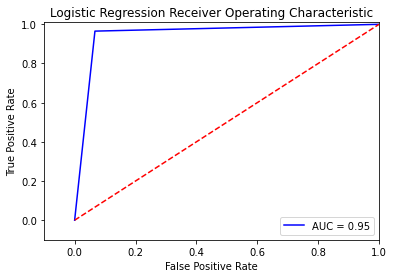

In [42]:
# plot Logistic Regression ROC curve
roc = metrics.roc_auc_score(y_test, y_hat) 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat) 
roc_auc = auc(fpr,tpr)

plt.title('Logistic Regression Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The Logistic Regression model and SVC model both have a high Recall metric of 97%. Both models have an AUC of 0.95. Given the potential high cost of fraud, one recommendation would be to use an ensemble of both models, and consider the transaction a fraud if either model predicts a fraud.